# Automatic Categorization of Youtube Videos from User Input

## Failure as an investment in future success

Going into this project I read numerous methods that would probably render better results. It is however a very real and practical problem websites face or have faced.  It was not my goal to definitively prove my hypothesis, but
to explore the various weaknesses in the models so that I might better understand how they works and what the strengths and weaknesses are when 
approaching problems in the future. Often times in education on topics the ideal solutions are focused on ideal solutions handed over rather than the building up of options from a
historical perspective. Following a path that winds through past failures is where many of the successes in ML have are found and without that I believe 
people loose perspective and intuition. This is undoubtedly a naive attempt at a complex problem. However, I acquired a far better understanding of
NLP, Precision, Recall, F1, AUC and ROC evaluation metrics, and confusion matrices.

## Hypothesis
Google goes to great lengths to properly categorize Youtube videos correctly.  Their algorithm uses a myriad of data and sentiment anaylisis techniques
drawing upon the deep well of various information and other products they have in their wheel house. Since the barrier of entry has lowered into ML, 
it was my hypothesis that it may be possible to develop a method that may work as well with far less data neccesary solely relying on limited user 
generated data and powerful open source sklearn libraries. 

This whitepaper describes how Google uses there data to accomplish similar tasks on Youtube: https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41156.pdf written by Vinvent Simone of Gogle Paris.

## Results
The features kept in the models only accounted for user generated information at the time of video submission. These were 7 features ['channel_title', 'comments_disabled', 'ratings_disabled', 'category_names', 'title', 'description', 'tags'].  By devining custom tags from the description that encompassed topic specific words from a bank as well as utilizing topic analysis via LDA I was able to reach promising AUC scores with Random Forest (72.5%)
and a One vs All Linear Support Vector Machine. The LSVM resulted in an average AUC for each class of 80%!. 


## Where to go from here?
It would be advantageous to also further extened a word bank for each category denoting various labels as well as analyzing the thumbnail and video
in a CNN. Although the results show it is possible categorize the videos with a fair degree of accuracy and precision the recall faltered below
what I believe a production ready model would need.

This project marks the 9th week of Data Science study, and 12th week of coding I have pursued in 2019. Prior to this I have had no experience 
with either topics.  

## Content

This dataset includes several months (and counting) of data on daily trending YouTube videos. Data is included for the US, GB, DE, CA, and FR regions (USA, Great Britain, Germany, Canada, and France, respectively), with up to 200 listed trending videos per day. I chose to yse only the English primary language sets due to UTF-8 parsing restrictions from the other languages. 

Each region’s data is in a separate file. Data includes the video title, channel title, publish time, tags, views, likes and dislikes, description, and comment count.

The data also includes a category_id field, which varies between regions. To retrieve the categories for a specific video, find it in the associated JSON. One such file is included for each of the five regions in the dataset.

For more information on specific columns in the dataset refer to the column metadata.
This dataset of the trending videos can be found at https://www.kaggle.com/datasnaek/youtube-new furnished by https://mitchelljolly.com/.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import glob
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
import category_encoders as ce
#This is gold
import pandas_profiling as pp
# Import the nltk package
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
nltk.download("punkt")
# NLTK Stop words
from nltk.corpus import stopwords
pd.options.display.max_columns = 500 
pd.options.display.max_rows = 500
pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_seq_items = 2000
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\darek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#define a function to map our label names to the codes for clarity as the data is analyzed

In [3]:

def category_name(path):
    with open(path) as json_file:  
        data = json.load(json_file)
    category_info_list=[]
    for row in data['items']:
        id_info=row['id']
        category_name=row['snippet']['title']
        categoty_info=(id_info ,category_name)
        category_info_list.append(categoty_info)
    return(dict(category_info_list))

In [4]:
def missplot(df):
  df.isna().sum().plot.bar(figsize=(16,6), color='red')
  plt.title(f'Count of Missing Values per {df} Column ')
  plt.ylabel('Counts')
  plt.show()

In [5]:
path = "D:\DATASETS\youtube-new\\"
for name in glob.glob(path+'*.*'):
    print(name)

D:\DATASETS\youtube-new\CAvideos.csv
D:\DATASETS\youtube-new\CA_category_id.json
D:\DATASETS\youtube-new\DEvideos.csv
D:\DATASETS\youtube-new\DE_category_id.json
D:\DATASETS\youtube-new\FRvideos.csv
D:\DATASETS\youtube-new\FR_category_id.json
D:\DATASETS\youtube-new\GBvideos.csv
D:\DATASETS\youtube-new\GB_category_id.json
D:\DATASETS\youtube-new\GoogleYoutubeClassification.pdf
D:\DATASETS\youtube-new\INvideos.csv
D:\DATASETS\youtube-new\IN_category_id.json
D:\DATASETS\youtube-new\JPvideos.csv
D:\DATASETS\youtube-new\JP_category_id.json
D:\DATASETS\youtube-new\KRvideos.csv
D:\DATASETS\youtube-new\KR_category_id.json
D:\DATASETS\youtube-new\MXvideos.csv
D:\DATASETS\youtube-new\MX_category_id.json
D:\DATASETS\youtube-new\PrecisionRecall.png
D:\DATASETS\youtube-new\RUvideos.csv
D:\DATASETS\youtube-new\RU_category_id.json
D:\DATASETS\youtube-new\USvideos.csv
D:\DATASETS\youtube-new\US_category_id.json


In [6]:
us = pd.read_csv(path +'USvideos.csv')
canada = pd.read_csv(path +'CAvideos.csv')
gbritain = pd.read_csv(path +'GBvideos.csv')
print(us.shape)
print(canada.shape)
print(gbritain.shape)

(40949, 16)
(40881, 16)
(38916, 16)


In [7]:
us.video_id.value_counts()[:20]

j4KvrAUjn6c    30
QBL8IRJ5yHU    29
8h--kFui1JA    29
r-3iathMo7o    29
NBSAQenU2Bk    29
t4pRQ0jn23Q    29
MAjY8mCTXWk    29
iILJvqrAQ_w    29
WIV3xNz8NoM    28
6S9c5nnDd_s    28
vjSohj-Iclc    28
2PH7dK6SLC8    28
YI3tsmFsrOg    28
UfKmSfgFxi8    28
ulNswX3If6U    28
mdWcaWBxxcY    28
1purAy2MsOc    27
Xpv-sEKl1B4    27
TjXQzRWmb_I    27
H7gh2fmdjCU    27
Name: video_id, dtype: int64

In [8]:
us[us.video_id == 'j4KvrAUjn6c']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
34550,j4KvrAUjn6c,18.14.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",2131702,54280,4696,10705,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! TIX ON SALE NOW!! https://www.d...
34752,j4KvrAUjn6c,18.15.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",3906727,77378,12160,15874,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...
34901,j4KvrAUjn6c,18.15.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",3906727,77378,12160,15874,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...
34966,j4KvrAUjn6c,18.16.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",4862649,90451,14792,18035,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...
35180,j4KvrAUjn6c,18.17.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",5665445,101461,16170,19395,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...
35396,j4KvrAUjn6c,18.18.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",6290796,110373,17131,20365,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...
35600,j4KvrAUjn6c,18.19.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",6773604,116508,17787,20941,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...
35804,j4KvrAUjn6c,18.20.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",7204004,121673,18323,21459,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...
36035,j4KvrAUjn6c,18.21.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",7512530,125317,18633,21812,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...
36245,j4KvrAUjn6c,18.22.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",7740671,128377,18901,22052,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...


In [9]:
canada[canada.video_id == 'j4KvrAUjn6c']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
34520,j4KvrAUjn6c,18.14.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",2131702,54280,4696,10705,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! TIX ON SALE NOW!! https://www.d...
34698,j4KvrAUjn6c,18.15.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",3906727,77379,12161,15874,https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,False,False,False,BEST MOM EVER! WANT TO SEE US IN NYC & NJ?!BUY...


In [10]:
us_category_ids = category_name(path+"US_category_id.json")
canada_category_ids = category_name(path+"CA_category_id.json")
gb_category_ids = category_name(path+"GB_category_id.json")

In [11]:
#US labels
category_list=us_category_ids
category_names=[]
for i in us.category_id:
    category_name=category_list.get(str(i))
    category_names.append(category_name)

us['category_names']=category_names


In [12]:
#Canada labels
category_list=canada_category_ids
category_names=[]
for i in canada.category_id:
    category_name=category_list.get(str(i))
    category_names.append(category_name)

canada['category_names']=category_names

In [13]:
#Great Britain Labels
category_list=gb_category_ids
category_names=[]
for i in gbritain.category_id:
    category_name=category_list.get(str(i))
    category_names.append(category_name)

gbritain['category_names']=category_names

In [14]:
#combine the countries
df =pd.concat([canada, us, gbritain])
df.shape

(120746, 17)

## The Power of the Pandas Profiling Report

__This is a priceless one liner that will generate much of the data exploration methods in an html format that is easy to read as well as giving 
you vital skew, missing data and other feature characteristics needed to make sound decisions that would normally be between 20-30 lines of code for the information alone__

In [15]:
pp.ProfileReport(df)

In [16]:
#Check for duplicates betweeen the countries trending videos
df.video_id.value_counts()[:20]

8h--kFui1JA    70
VYOjWnS4cMY    69
vjSohj-Iclc    65
UUkn-enk2RU    64
zxwfDlhJIpw    64
l884wKofd54    64
5GHXEGz3PJg    63
CX11yw6YL1w    63
i5qOzqD9Rms    61
ffxKSjUwKdU    61
tJfDBSWYqU8    61
pFc6I0rgmgY    61
BspHjvU11y4    61
6SuMbFuKDf8    60
u_C4onVrr8U    59
vjI4Alon-3Q    59
iWZmdoY1aTE    58
KUUjtUP2CrE    57
M4ZoCHID9GI    57
mdWcaWBxxcY    57
Name: video_id, dtype: int64

In [17]:
#Are all of the duplicates labeled the same?
df[df.video_id == '8h--kFui1JA']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_names
33763,8h--kFui1JA,18.10.05,Sam Smith - Pray (Official Video) ft. Logic,SamSmithWorldVEVO,10,2018-05-09T17:00:00.000Z,"Sam|""Smith""|""Pray""|""Capitol""|""Pop""",641944,72641,1133,4357,https://i.ytimg.com/vi/8h--kFui1JA/default.jpg,False,False,False,"Stream, Download and Listen to Pray feat. Logi...",Music
33954,8h--kFui1JA,18.11.05,Sam Smith - Pray (Official Video) ft. Logic,SamSmithWorldVEVO,10,2018-05-09T17:00:00.000Z,"Sam|""Smith""|""Pray""|""Capitol""|""Pop""",2174315,148689,3725,7907,https://i.ytimg.com/vi/8h--kFui1JA/default.jpg,False,False,False,"Stream, Download and Listen to Pray feat. Logi...",Music
34181,8h--kFui1JA,18.12.05,Sam Smith - Pray (Official Video) ft. Logic,SamSmithWorldVEVO,10,2018-05-09T17:00:00.000Z,"Sam|""Smith""|""Pray""|""Capitol""|""Pop""",3117295,184871,4470,8916,https://i.ytimg.com/vi/8h--kFui1JA/default.jpg,False,False,False,"Stream, Download and Listen to Pray feat. Logi...",Music
34443,8h--kFui1JA,18.13.05,Sam Smith - Pray (Official Video) ft. Logic,SamSmithWorldVEVO,10,2018-05-09T17:00:00.000Z,"Sam|""Smith""|""Pray""|""Capitol""|""Pop""",3974218,209155,4934,9619,https://i.ytimg.com/vi/8h--kFui1JA/default.jpg,False,False,False,"Stream, Download and Listen to Pray feat. Logi...",Music
33750,8h--kFui1JA,18.10.05,Sam Smith - Pray (Official Video) ft. Logic,SamSmithWorldVEVO,10,2018-05-09T17:00:00.000Z,"Sam|""Smith""|""Pray""|""Capitol""|""Pop""",641944,72641,1133,4357,https://i.ytimg.com/vi/8h--kFui1JA/default.jpg,False,False,False,"Stream, Download and Listen to Pray feat. Logi...",Music
33952,8h--kFui1JA,18.11.05,Sam Smith - Pray (Official Video) ft. Logic,SamSmithWorldVEVO,10,2018-05-09T17:00:00.000Z,"Sam|""Smith""|""Pray""|""Capitol""|""Pop""",2174315,148686,3725,7907,https://i.ytimg.com/vi/8h--kFui1JA/default.jpg,False,False,False,"Stream, Download and Listen to Pray feat. Logi...",Music
34164,8h--kFui1JA,18.12.05,Sam Smith - Pray (Official Video) ft. Logic,SamSmithWorldVEVO,10,2018-05-09T17:00:00.000Z,"Sam|""Smith""|""Pray""|""Capitol""|""Pop""",3117295,184871,4470,8916,https://i.ytimg.com/vi/8h--kFui1JA/default.jpg,False,False,False,"Stream, Download and Listen to Pray feat. Logi...",Music
34379,8h--kFui1JA,18.13.05,Sam Smith - Pray (Official Video) ft. Logic,SamSmithWorldVEVO,10,2018-05-09T17:00:00.000Z,"Sam|""Smith""|""Pray""|""Capitol""|""Pop""",3974218,209148,4933,9624,https://i.ytimg.com/vi/8h--kFui1JA/default.jpg,False,False,False,"Stream, Download and Listen to Pray feat. Logi...",Music
34814,8h--kFui1JA,18.15.05,Sam Smith - Pray (Official Video) ft. Logic,SamSmithWorldVEVO,10,2018-05-09T17:00:00.000Z,"Sam|""Smith""|""Pray""|""Capitol""|""Pop""",5303674,235414,5767,10359,https://i.ytimg.com/vi/8h--kFui1JA/default.jpg,False,False,False,"Stream, Download and Listen to Pray feat. Logi...",Music
35022,8h--kFui1JA,18.16.05,Sam Smith - Pray (Official Video) ft. Logic,SamSmithWorldVEVO,10,2018-05-09T17:00:00.000Z,"Sam|""Smith""|""Pray""|""Capitol""|""Pop""",6126929,246832,6077,10507,https://i.ytimg.com/vi/8h--kFui1JA/default.jpg,False,False,False,"Stream, Download and Listen to Pray feat. Logi...",Music


In [ ]:
#Combined Target Values for the dataframe
fig = plt.figure(figsize=(16,9))
plt.style.use('dark_background')
plt.title("Target Label Totals : YouTube Trending Videos", fontsize=25)
plt.xticks(fontsize=18)
df['category_names'].value_counts().plot.bar(color='lightblue')
plt.show();

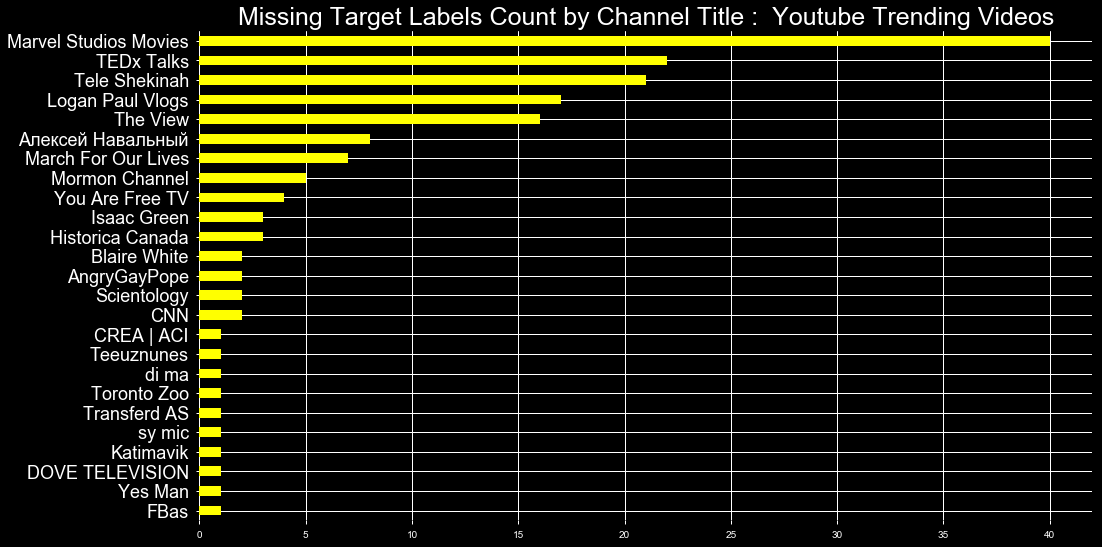

In [19]:
plt.figure(figsize=(16,9))
plt.style.use('dark_background')
plt.title("Missing Target Labels Count by Channel Title :  Youtube Trending Videos", fontsize=25)
plt.yticks(fontsize=18)
df[df.category_names.isna()].channel_title.value_counts().sort_values().plot.barh(color="yellow");

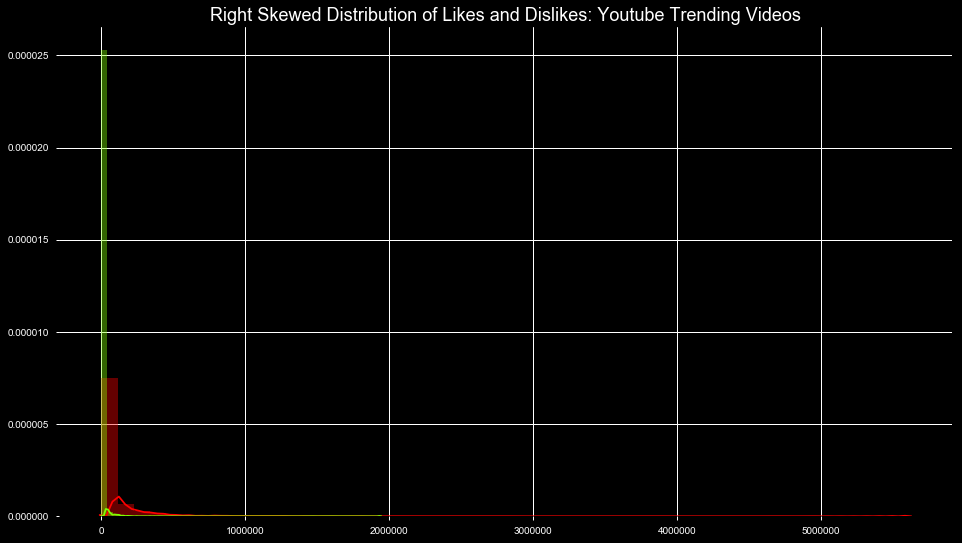

In [21]:
plt.figure(figsize=(16,9))
ax = plt.subplot(111)
plt.style.use('dark_background')
plt.title("Right Skewed Distribution of Likes and Dislikes: Youtube Trending Videos", fontsize=18)
plt.xticks(np.arange(0, 6000000, 1000000))
sns.distplot(df.likes, axlabel=False, color='red')
sns.distplot(df.dislikes,axlabel=False, color='chartreuse');

In [22]:
#What is the baseline accuracy if we guess the majority class everytime?

y_train = df['category_names']
y_train.value_counts(normalize=True)

Entertainment           0.2698
Music                   0.1987
People & Blogs          0.0849
Comedy                  0.0751
Howto & Style           0.0670
News & Politics         0.0653
Film & Animation        0.0579
Sports                  0.0570
Science & Technology    0.0338
Gaming                  0.0327
Education               0.0257
Pets & Animals          0.0151
Travel & Events         0.0074
Autos & Vehicles        0.0073
Shows                   0.0017
Nonprofits & Activism   0.0005
Movies                  0.0000
Name: category_names, dtype: float64

In [23]:
def wrangle(X):

    '''Function to preprocess/wrangle data into a usable form'''
    
    X = X.copy()
    
    #Print our original shape to compare after the function
    
    print(f'Before Wrangle Dataframe Shape: {X.shape}')
           
    #drop duplicate rows between 
    
    X = X.drop_duplicates(['video_id'], keep='first')
    
    #If the video was removed or errored we are not interested
    #in using it to train or evaulate on 
    
    X = X[X.video_error_or_removed == False]
    
    #We only want the correctly labeled data to train and evaluate
    
    X = X[X['category_names'].isna() == False]

    X = X.drop(columns=[
    'video_id','publish_time','likes','dislikes',
    'thumbnail_link','video_error_or_removed',
    'trending_date','category_id','views','comment_count'])
    
    # Quick and Dirty Lemmenization
    X["title_cleaned"] = X["title"].str.lower()
    X["title_cleaned"] = X["title_cleaned"].str.replace(r'[^\w\s]+', '')

    X["description_cleaned"] = X["description"].str.lower()
    X["description_cleaned"] = X["description_cleaned"].str.replace(r'[^\w\s]+', '')

    X["tags_cleaned"] = X["tags"].str.lower()
    X["tags_cleaned"] = X["tags_cleaned"].str.replace(r'[^\w\s]+', '')
    X['tags_cleaned'] = X['tags_cleaned'].str.replace("|"," ")
    X['tags_cleaned'] = X['tags_cleaned'].str.replace('\"',' ')
    
    X = X.drop(columns=["tags","description","title"])
    X = X.rename(columns={'title_cleaned':'title', 'description_cleaned':'description',
                'tags_cleaned':'tags'})
    
    #fill na values for descriptions

    X['description'] = X["description"].fillna("MISSING")
   
    print(f'New Dataframe Shape: {X.shape}')
    print(f'The columns left are:\n{X.columns.tolist()}')
    print(f'The NAN values are:\n{X.isna().sum()}')
    
    #reset the index numbers so that there are no duplicates after the merge
    
    X = X.reset_index(drop=True)
    
    return X


In [24]:
df = wrangle(df)

Before Wrangle Dataframe Shape: (120746, 17)
New Dataframe Shape: (30246, 7)
The columns left are:
['channel_title', 'comments_disabled', 'ratings_disabled', 'category_names', 'title', 'description', 'tags']
The NAN values are:
channel_title        0
comments_disabled    0
ratings_disabled     0
category_names       0
title                0
description          0
tags                 0
dtype: int64


__Taking a look at the three features properties below before going into topic generation. Large Values here may mean they are not suited to 
attempting Count Vectorization or LDA.__

In [25]:
document_lengths = np.array(list(map(len, df['description'].str.split(' '))))

print("The average number of words in a video description is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a video description is: {}.".format(min(document_lengths)))
print("The maximum number of words in a video description is: {}.\n".format(max(document_lengths)))

document_lengths2 = np.array(list(map(len, df['title'].str.split(' '))))

print("The average number of words in a video title is: {}.".format(np.mean(document_lengths2)))
print("The minimum number of words in a video title is: {}.".format(min(document_lengths2)))
print("The maximum number of words in a video title is: {}.\n".format(max(document_lengths2)))


document_lengths3 = np.array(list(map(len, df['tags'].str.split(' '))))

print("The average number of words in a video tags is: {}.".format(np.mean(document_lengths3)))
print("The minimum number of words in a video tags is: {}.".format(min(document_lengths3)))
print("The maximum number of words in a video tags is: {}.\n".format(max(document_lengths3)))

The average number of words in a video description is: 108.32688619982808.
The minimum number of words in a video description is: 1.
The maximum number of words in a video description is: 1124.

The average number of words in a video title is: 9.370131587647954.
The minimum number of words in a video title is: 1.
The maximum number of words in a video title is: 30.

The average number of words in a video tags is: 18.048171659062355.
The minimum number of words in a video tags is: 1.
The maximum number of words in a video tags is: 87.



## Can extract some information to help categorize the data?

In [26]:
#The labels for our data and the counts for comparison later
df.category_names.value_counts(normalize=True)

Entertainment           0.3214
News & Politics         0.1129
People & Blogs          0.1015
Music                   0.0818
Sports                  0.0800
Comedy                  0.0762
Howto & Style           0.0588
Film & Animation        0.0472
Gaming                  0.0319
Science & Technology    0.0298
Education               0.0252
Pets & Animals          0.0107
Autos & Vehicles        0.0102
Travel & Events         0.0082
Shows                   0.0035
Nonprofits & Activism   0.0004
Movies                  0.0000
Name: category_names, dtype: float64

## Do some word association

__In order to further focus in our model this is an attempt at extracting a tag where each description is evaluated to contain a label important key
word into another feature of the data point. If a description has any of the words associated from a brief word bank it most likely belongs to that 
label.__

In [27]:
# this is where a synonym word bank file or category corpus could better
#speed up and extended the abilities

In [28]:
music_words = ['music','song, punjabi',
               'musicvideo','artist','rap',
               'rock','country','listen']
for word in music_words:
    df['music_tag'] = df['description'].str.contains(word)
                    
ent_words = ['entertainment','entertain']
for word in ent_words:
    df['ent_tag'] = df['description'].str.contains(word)
    
pol_words = [
    'politics','republican','democrat','news','world'
    'white house','headlines','immigration'
    'trump','president','congress','senate', 'press']
for word in pol_words:
    df['pol_tag'] = df['description'].str.contains(word)

blog_words =['blog','vlog','diary']
for word in blog_words:
    df['blog_tag'] = df['description'].str.contains(word)
    
sport_words =  ['sports','basketball','football',
                'baseball','soccer','score']
for word in sport_words:
    df['sport_tag'] = df['description'].str.contains(word)

com_words =  ['comedy','snl','funny','laugh','lol','vine']
for word in com_words:
    df['com_tag'] = df['description'].str.contains(word)

style_words = [
    'style','fashion','clothes','clothing',
    'makeup','designer','']
for word in style_words:
    df['style_tag'] = df['description'].str.contains(word)

anim_words = ['cartoon','pixar','animation','animated','anime']
for word in anim_words:
    df['anim_tag'] = df['description'].str.contains(word)

gam_words =['gamer','playstation','walkthrough','nintendo','fortnite','fps']
for word in gam_words:
    df['game_tag'] = df['description'].str.contains(word)

sci_words = ['science','theory','technology','scientist','scientists']   
for word in sci_words:
    df['sci_tag'] = df['description'].str.contains(word)

edu_words = ['education','school','teacher','college','exam']   
for word in edu_words:
    df['edu_tag'] = df['description'].str.contains(word)

pet_words = ['pet','pets','animal','dog','cat']
for word in pet_words:
    df['pet_tag'] = df['description'].str.contains(word)

auto_words = ['auto','car','race','wheel','tire','tesla']
for word in auto_words:
    df['auto_tag'] = df['description'].str.contains(word)
    
trav_words = ['vacation','tour','travel','traveler','destination','vaca']
for word in trav_words:
    df['trav_tag'] = df['description'].str.contains(word)
    
mov_words = ['movie', 'movies','film','actor','actress','sundance','cinema']
for word in mov_words:
    df['movie_tag'] = df['description'].str.contains(word)
    
sho_words = ['tv','series','episode','e1','show','miniseries']
for word in sho_words:
    df['show_tag'] = df['description'].str.contains(word)
    
char_words = [
    'charity','nonprofit','cause','donation',
    'poverty','starving','shelter']
for word in char_words:
    df['charity_tag'] = df['description'].str.contains(word)


In [29]:
#lets look at the top three labels counts
print(f'Entertainment Tags {len(df[df.ent_tag == True])}')
print(f'Politics Tags {len(df[df.pol_tag == True])}')
print(f'Blog Tags {len(df[df.blog_tag == True])}')

Entertainment Tags 2173
Politics Tags 1472
Blog Tags 17


## CountVectorize the Description Feature for Category Extraction

__"Convert a collection of text documents to a matrix of token counts__

__This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix__

__If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data"__



In [30]:
words = pd.DataFrame(pd.Series(' '.join(df['description']).split()).value_counts()[:100])


In [31]:
# NLTK Stop words

words = words.reset_index()
words = words.rename(columns={"index":"word", "0":"count"})

stop_words = stopwords.words('english')
stop_words.extend([
    'from', 'subject', 're', 'edu', 'use',
    'follow', 'http', 'www', 'facebook',
    'instagram','twitter', 'youtube',
    'channel','subscribe','video',
    'subscribers', 'like'
])
#What other words may have little value from the top 100?
tops = list(set(words.word)-set(stop_words))
#Add them to the list of words to exclude
stop_words.extend(tops)

In [32]:

tf_vectorizer = CountVectorizer(ngram_range = (1,2),
                                stop_words = stop_words,
                                max_df = 0.8, #the word is ignored if in more than 80% of corpus
                                min_df = 5) #the word shows up in a minimum of 5 times of corpus

dtm_tf = tf_vectorizer.fit_transform(df['description'])

dtm_feature_names = tf_vectorizer.get_feature_names()

print('Document Term Matrix Shape for description: {}'.format(dtm_tf.shape))


Document Term Matrix Shape for description: (30246, 85142)


### There are 17 distinct target categories to predict, so starting with this in the LDA Model appears logical

__LDA results in a topic modeling method that results in a probability distribution of associated words with topics from each description in this case.  Each topic that it deduces from the descriptions are like the words emergence probabilities and each will have an associated vocabulary as well as translate to a good feature matrix__

from Wikipedia:

"For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model."

In [33]:
n_topics = 17
lda_tf = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_tf.fit(dtm_tf)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=17, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [34]:
#Top 10 words for each Category 
def print_top_words(model, feature_names, n_top_words=10):
    
    '''prints the top 10 words from LDA topics'''
    
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [35]:

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_tf, tf_feature_names)


Topics in LDA model:
Topic #0: song punjabi priyamanaval ufc entertainment serial songs mr directed find
Topic #1: et le les en pour sur des cbc un que
Topic #2: crime 2017 film awards album top patrol social movie man
Topic #3: im link know dont code see young links go made
Topic #4: msnbc vs night hum netflix nbc drama seth hd real
Topic #5: cbs stephen movie colbert episodes stephen colbert stars pm click access
Topic #6: missing des troom un blagues du en une les et
Topic #7: food street street food corden james national của delicious những và
Topic #8: via warner chappell warner chappell via warner nba fine react iphone podcast
Topic #9: الحلقة مسلسل من البيت مسلسل البيت الكبير البيت الكبير من مسلسل عشر tmz
Topic #10: kimmel jimmy jimmy kimmel voice trump president comedy tom movie tweets
Topic #11: rani vaani family awards tamil film india children wwe fox
Topic #12: tonight jimmy life troom fallon jimmy fallon copyright starring please funny
Topic #13: mehta taarak today tapu j

__Topic one has song and punjabi as correctly associating with each other. There are definetly seperations that seem to make sense as coroborating to 
make a topic cohesive, but it seems that some namese dominate some topics, such as chappel, Jimmy Fallon or American Idol. American Idol in itself is music and entertainment so it is interesting to see how it was sequestered. I can imagine there is a bias in the data as a result of these being the 
trending videos and not merely a random sample.__

In [36]:
# Extract Topic Distributions from LDA model for each video
col_names = ["Desc. Topic {0}".format(x) for x in range(0, n_topics)]
topic_dist = lda_tf.transform(dtm_tf)
topic_df = pd.DataFrame(topic_dist, columns = col_names)

# Join topic dataframe with numerical features from Method #1
df2 = pd.concat([df, topic_df], axis=1)

#check the shape vs the old one
print(f'Original Dataframe Shape: {df.shape}')
print(f'New Dataframe Shape: {df2.shape}\n')


Original Dataframe Shape: (30246, 24)
New Dataframe Shape: (30246, 41)



In [37]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()



In [38]:
# Visualize the topics
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=            x       y  topics  cluster    Freq
topic                                         
3     -0.1339  0.0693       1        1 15.3728
2     -0.1032  0.0420       2        1  7.6843
12    -0.1052  0.0802       3        1  7.6842
16    -0.0962  0.0524       4        1  5.9770
11     0.0894 -0.3630       5        1  5.9696
4     -0.0669  0.0196       6        1  5.7099
8     -0.0146 -0.0048       7        1  5.4690
1      0.1981  0.1193       8        1  5.3057
10    -0.0202 -0.0466       9        1  5.1854
5     -0.0416 -0.0030      10        1  4.9453
7     -0.0174  0.0071      11        1  4.9142
13    -0.0117 -0.0603      12        1  4.9094
14    -0.0875  0.0378      13        1  4.7159
15     0.1128  0.0302      14        1  4.6171
0     -0.0577  0.0071      15        1  4.0473
9      0.0464 -0.1212      16        1  3.8883
6      0.3093  0.1340      17        1  3.6047, topic_info=      Category      Freq                                               Term  \
42070  Default 2478.0000                                              jimmy   
81039  Default 1825.0000                                             الحلقة   
82977  Default 1827.0000                                              مسلسل   
83054  Default 1838.0000                                                 من   
19679  Default 2184.0000                                                 et   
43562  Default 1621.0000                                             kimmel   
80918  Default 1414.0000                                              البيت   
50556  Default 1529.0000                                              msnbc   
82981  Default 1319.0000                                        مسلسل البيت   
81292  Default 1327.0000                                             الكبير   
80919  Default 1283.0000                                       البيت الكبير   
16017  Default 1651.0000                                                des   
83081  Default 1249.0000                                           من مسلسل   
73966  Default 1594.0000                                              troom   
10192  Default 1472.0000                                                cbs   
49644  Default 1279.0000                                            missing   
42078  Default 1214.0000                                       jimmy kimmel   
45072  Default 1541.0000                                                les   
44708  Default 1278.0000                                                 le   
18870  Default 1386.0000                                                 en   
61338  Default 1175.0000                                               rani   
75113  Default 1352.0000                                                 un   
22377  Default 2166.0000                                               food   
70339  Default 1464.0000                                                sur   
74085  Default 1787.0000                                              trump   
59259  Default 1241.0000                                               pour   
52913  Default 2536.0000                                              night   
76285  Default 1643.0000                                                via   
77179  Default 2291.0000                                                 vs   
52330  Default  969.0000                                                nfl   
50932   Topic1  614.5444                                           mythical   
74552   Topic1  565.0217                                              turks   
79767   Topic1  565.0217                                        young turks   
10335   Topic1  499.3284                                               cenk   
4266    Topic1  495.2858                                                ant   
75891   Topic1  402.3045                                              uygur   
10336   Topic1  401.2938                                         cenk uygur   
50941   Topic1  291.1312                                      

__Visually you can see an overlap in 12 of the 17 topics generated from the text. This undoubtedly means they share words with the each other. The relevance metric slider can be adjusted so that at the 1 position the topics vizualization of words associated with the topic denote overall term frequency or salience, meaning how much they are spread throughout the corpus. A zero position contrast terms unique to the topic versus how often they appear in the rest of the text. 14, 5, 16, 8, and 17 make great segregation from the heard and 14 is particularly impressive as a sports category. Not only does it get various sports by name but players and websites as well in the top 30.__

## Title Category Vectorized

#### Again lets see what our word bank of top frequency for this feature can show us

In [39]:
words_title = pd.DataFrame(pd.Series(' '.join(df['title']).split()).value_counts()[:100])
words_title = words_title.reset_index()
words_title = words_title.rename(columns={"index":"word", "0":"count"})
stop_wordz = stopwords.words('english')
topz = list(set(words_title.word)-set(stop_wordz))
#Add them to the list of words to exclude
stop_wordz.extend([
     '2018','10','2017','7',
    'la','2','1','6','4','5',
     '3','video'

])
tf_vectorizer = CountVectorizer(ngram_range = (1,2),
                                stop_words = stop_wordz,
                                max_df = 0.6, #the word is ignored if in more than 60% of corpus
                                min_df = 2) #the word shows up in a minimum of 2 observations

dtm_tf_title  = tf_vectorizer.fit_transform(df['title'])

dtm_feature_names_title = tf_vectorizer.get_feature_names()

print('Document Term Matrix Shape for description: {}'.format(dtm_tf.shape))

Document Term Matrix Shape for description: (30246, 85142)


#### Since these words exist in the title of the Videos and thus have more correlation to the actual categories they would have to be "cherry picked" instead of automated for removal where they may be redundant. Since the goal is to have a autonomous system of video categorization via the model if this were t be succesful as a cyclical train, predict, update paradigm it would be futile to hand pick terms now. Instead, opting for generic removals  without blindly using the set differences is optimal.
#### The choice to remain using 17 topics as the target is conceptually, there may be a consistency bonus between the features by doing so. If in one feature the model designates the topic more than another either the title topic will reinforce that probability or balance it by pulling it in another destinct class for the trees later to divide. At least that is the hope.

In [40]:
n_topics = 17
lda_tf_title = LatentDirichletAllocation(n_components=n_topics, random_state=10)
lda_tf_title.fit(dtm_tf_title)
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_tf_title, tf_feature_names)


Topics in LDA model:
Topic #0: fortnite les trump de live hacks des battle got like
Topic #1: episode rani ரண vaani vaani rani vaani rani episode வண வண ரண ரண vs
Topic #2: official music audio official music ft live official audio new love feat
Topic #3: full episode ep full episode star makeup wars crime patrol star wars
Topic #4: life trump first real make trumps makes jimmy get justin
Topic #5: episode drama paul juan digital logan ary ary digital digital drama logan paul
Topic #6: kids game trump joe react msnbc morning test taste vs
Topic #7: vs game highlights nba game highlights full full game season 201718 cavaliers
Topic #8: official teaser react episode netflix youtube best doki الحلقة watch
Topic #9: episode tv promo top season drama big american podcast hum
Topic #10: news super trump breaking bowl super bowl episode race president time
Topic #11: الحلقة مسلسل james first espn take lebron royal meghan season
Topic #12: trailer official official trailer hd trump street food 

In [41]:
# Extract Topic Distributions from LDA model for each video
col_names = ["Title_Topic {0}".format(x) for x in range(0, n_topics)]
topic_dist = lda_tf_title.transform(dtm_tf_title)
topic_df_title = pd.DataFrame(topic_dist, columns = col_names)

# Join topic dataframe with numerical features from Method #1
df3 = pd.concat([df2, topic_df_title], axis=1)
print(f'Original Dataframe Shape: {df2.shape}')
print(f'New Dataframe Shape: {df3.shape}\n')
df3.head()

Original Dataframe Shape: (30246, 41)
New Dataframe Shape: (30246, 58)



,channel_title,comments_disabled,ratings_disabled,category_names,title,description,tags,music_tag,ent_tag,pol_tag,blog_tag,sport_tag,com_tag,style_tag,anim_tag,game_tag,sci_tag,edu_tag,pet_tag,auto_tag,trav_tag,movie_tag,show_tag,charity_tag,Desc. Topic 0,Desc. Topic 1,Desc. Topic 2,Desc. Topic 3,Desc. Topic 4,Desc. Topic 5,Desc. Topic 6,Desc. Topic 7,Desc. Topic 8,Desc. Topic 9,Desc. Topic 10,Desc. Topic 11,Desc. Topic 12,Desc. Topic 13,Desc. Topic 14,Desc. Topic 15,Desc. Topic 16,Title_Topic 0,Title_Topic 1,Title_Topic 2,Title_Topic 3,Title_Topic 4,Title_Topic 5,Title_Topic 6,Title_Topic 7,Title_Topic 8,Title_Topic 9,Title_Topic 10,Title_Topic 11,Title_Topic 12,Title_Topic 13,Title_Topic 14,Title_Topic 15,Title_Topic 16
0,EminemVEVO,False,False,Music,eminem walk on water audio ft beyoncé,eminems new track walk on water ft beyoncé is ...,eminemwalkonwateraftermathshadyinterscoperap,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0024,0.0024,0.4003,0.0024,0.0024,0.5208,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0024,0.0460,0.0024,0.0053,0.0053,0.2014,0.0053,0.0053,0.0053,0.0053,0.0053,0.0053,0.0053,0.0053,0.0053,0.0053,0.7184,0.0053,0.0053,0.0053
1,iDubbbzTV,False,False,Comedy,plush bad unboxing fan mail,still got a lot of packages probably will last...,plushbad unboxingunboxingfan mailidubbbztvidub...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0019,0.0019,0.0019,0.5165,0.0019,0.0019,0.0019,0.4199,0.0019,0.0019,0.0019,0.0019,0.0019,0.0019,0.0019,0.0371,0.0019,0.0065,0.0065,0.8954,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065
2,Rudy Mancuso,False,False,Comedy,racist superman rudy mancuso king bach lele ...,watch my previous video nnsubscribe httpswww...,racist supermanrudymancusokingbachracistsuperm...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0009,0.0324,0.0009,0.9538,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0042,0.0042,0.0042,0.0042,0.0042,0.7119,0.0042,0.0042,0.0042,0.0042,0.0042,0.0042,0.0042,0.0042,0.0042,0.2250,0.0042
3,nigahiga,False,False,Entertainment,i dare you going bald,i know its been a while since we did this show...,ryanhigahigatvnigahigai dare youidyrhpcdaresno...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0014,0.0014,0.0014,0.0999,0.0014,0.0014,0.0014,0.0014,0.0014,0.8791,0.0014,0.0014,0.0014,0.0014,0.0014,0.0014,0.0014,0.0147,0.0147,0.0147,0.5147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.2647
4,Ed Sheeran,False,False,Music,ed sheeran perfect official music video,httpsadgtytperfectn httpsatlanticrytalbumnsub...,edsheeraned sheeranacousticlivecoverofficialre...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,0.0007,0.2900,0.2069,0.0007,0.0144,0.0540,0.0007,0.0007,0.0007,0.0007,0.3596,0.0007,0.0007,0.0007,0.0007,0.0669,0.0007,0.6126,0.0059,0.2992,0.0059,0.0059,0.0059,0.0059,0.0059,0.0059,0.0059,0.0059,0.0059,0.0059,0.0059,0.0059,0.0059,0.0059


In [42]:
# Visualize the topics
pyLDAvis.sklearn.prepare(lda_tf_title, dtm_tf_title, tf_vectorizer)

PreparedData(topic_coordinates=            x       y  topics  cluster   Freq
topic                                        
3      0.1818  0.1953       1        1 6.6895
7      0.1715 -0.2050       2        1 6.5885
11     0.1050 -0.1261       3        1 6.4418
2     -0.1081  0.0987       4        1 6.2900
9      0.1002  0.0482       5        1 6.0593
4     -0.1109 -0.0448       6        1 6.0217
13    -0.1226 -0.0725       7        1 5.8711
5      0.1441  0.0583       8        1 5.8554
10     0.0012 -0.0174       9        1 5.7965
1      0.1164  0.0019      10        1 5.7514
16    -0.0683  0.1240      11        1 5.6919
6     -0.0890 -0.1061      12        1 5.6732
14    -0.0708  0.0395      13        1 5.6308
12    -0.0899  0.0282      14        1 5.5813
0     -0.1123 -0.0084      15        1 5.5774
8     -0.0323  0.0323      16        1 5.2735
15    -0.0160 -0.0462      17        1 5.2066, topic_info=      Category      Freq                   Term     Total  loglift  logprob
18478  Default 1081.0000               official 1081.0000  30.0000  30.0000
8728   Default 1878.0000                episode 1878.0000  29.0000  29.0000
10621  Default  797.0000                   game  797.0000  28.0000  28.0000
25711  Default  575.0000                trailer  575.0000  27.0000  27.0000
12093  Default  545.0000             highlights  545.0000  26.0000  26.0000
27093  Default 1269.0000                     vs 1269.0000  25.0000  25.0000
10435  Default 1190.0000                   full 1190.0000  24.0000  24.0000
10453  Default  341.0000           full episode  341.0000  23.0000  23.0000
8641   Default  453.0000                     ep  453.0000  22.0000  22.0000
17401  Default  485.0000                  music  485.0000  21.0000  21.0000
17701  Default  387.0000                    nba  387.0000  20.0000  20.0000
18510  Default  257.0000       official trailer  257.0000  19.0000  19.0000
25982  Default  755.0000                  trump  755.0000  18.0000  18.0000
23545  Default  286.0000                   song  286.0000  17.0000  17.0000
23584  Default  276.0000                  songs  276.0000  16.0000  16.0000
7931   Default  389.0000                  drama  389.0000  15.0000  15.0000
10645  Default  238.0000        game highlights  238.0000  14.0000  14.0000
26272  Default  365.0000                     tv  365.0000  13.0000  13.0000
2816   Default  255.0000                  audio  255.0000  12.0000  12.0000
5456   Default  335.0000              christmas  335.0000  11.0000  11.0000
19178  Default  213.0000                   paul  213.0000  10.0000  10.0000
13702  Default  194.0000                   juan  194.0000   9.0000   9.0000
20336  Default  187.0000                punjabi  187.0000   8.0000   8.0000
18497  Default  192.0000         official music  192.0000   7.0000   7.0000
10458  Default  195.0000              full game  195.0000   6.0000   6.0000
22428  Default  547.0000                 season  547.0000   5.0000   5.0000
23963  Default  255.0000                   star  255.0000   4.0000   4.0000
28724  Default  421.0000                 الحلقة  421.0000   3.0000   3.0000
14679  Default  217.0000                 latest  217.0000   2.0000   2.0000
2923   Default  215.0000                 awards  215.0000   1.0000   1.0000
10453   Topic1  340.7324           full episode  341.5746   2.7022  -3.9275
6402    Topic1  155.8185                  crime  156.6607   2.6992  -4.7099
19169   Topic1  150.3531                 patrol  151.1953   2.6990  -4.7456
6403    Topic1  139.4222           crime patrol  140.2644   2.6986  -4.8210
16548   Topic1  108.4514                  mehta  109.2936   2.6969  -5.0723
13813   Topic1  108.4514              ka ooltah  109.2936   2.6969  -5.0723
18660   Topic1  108.4514        ooltah chashmah  109.2936   2.6969  -5.0723
18659   Topic1  108.4514                 ooltah  109.2936   2.6969  -5.0723
5240    Topic1  108.4514               chashmah  109.2936   2.6969  -5.0723
16549   Topic1  108.4514               meht

## Now the Tag Information 

In [43]:
words_tag = pd.DataFrame(pd.Series(' '.join(df['tags']).split()).value_counts()[:100])
words_tag = words_tag.reset_index()
words_tag = words_tag.rename(columns={"index":"word", "0":"count"})
stop_wordc = stopwords.words('english')
topc = list(set(words_tag.word)-set(stop_wordc))
#Add them to the list of words to exclude
stop_wordc.extend([
     '2018','10','2017','7',
    'la','2','1','6','4','5',
     '3','new'

])

In [44]:
tf_vectorizer = CountVectorizer(ngram_range = (1,2),
                                stop_words = stop_wordc,
                                max_df = 0.8, #the word is ignored if in more than 80% of corpus
                                min_df = 2) #the word shows up in a minimum of 2 observations

dtm_tf_tags  = tf_vectorizer.fit_transform(df['tags'])

dtm_feature_names_tag = tf_vectorizer.get_feature_names()

print('Document Term Matrix Shape for description: {}'.format(dtm_tf.shape))

Document Term Matrix Shape for description: (30246, 85142)


In [45]:
n_topics = 17
lda_tf_tags = LatentDirichletAllocation(n_components=n_topics, random_state=10)
lda_tf_tags.fit(dtm_tf_tags)
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_tf_tags, tf_feature_names)


Topics in LDA model:
Topic #0: serialkuladheivam tv sun episode sun tv tv serialkuladheivam edge super life ball
Topic #1: episode take vs doki game smith james today tvtelevisionfunnytalk panther
Topic #2: mythical food de link rhett street taste good morning good mythical
Topic #3: ما الأحد time el day reaction في tounsiaelhiwar tounsiaelhiwar ettounsidenya okhraoumour
Topic #4: vs game paul full full game iphone norton highlights season cavaliers
Topic #5: memes got volcano sports memesdank big talent dead comment show
Topic #6: music christmas love songs trump wrestling night ईमचसपरसटरवयवसयक डबल डबल ईमचसपरसटरवयवसयक
Topic #7: vs wars last real madrid star episode news tv madrid vs
Topic #8: none rogan flash bowl anatomy tv season episode king tamil
Topic #9: crime patrol know entertainment true patrolcrime patrolcrime patrol televisionanoop latest caseindian televisionanoop
Topic #10: office البيت world make pakistani 2018best الكبير dramasary digital البيت الكبير
Topic #11: late h

In [46]:
# Extract Topic Distributions from LDA model for each video
col_names = ["Tags Topic {0}".format(x) for x in range(0, n_topics)]
topic_dist = lda_tf_tags.transform(dtm_tf_tags)
topic_df_tags = pd.DataFrame(topic_dist, columns = col_names)

# Join topic dataframe with numerical features from Method #1
df4 = pd.concat([df3, topic_df_tags], axis=1)
print(f'Original Dataframe Shape: {df3.shape}')
print(f'New Dataframe Shape: {df4.shape}\n')

Original Dataframe Shape: (30246, 58)
New Dataframe Shape: (30246, 75)



In [47]:
# Visualize the topics
pyLDAvis.sklearn.prepare(lda_tf_tags, dtm_tf_tags, tf_vectorizer)

PreparedData(topic_coordinates=            x       y  topics  cluster   Freq
topic                                        
9      0.1643  0.2047       1        1 7.5853
4     -0.2384  0.0522       2        1 7.0900
1     -0.2279  0.0525       3        1 6.8513
13     0.0953 -0.1889       4        1 6.5742
14     0.0134 -0.0872       5        1 6.4685
2      0.0641  0.0956       6        1 6.3344
5     -0.0944  0.0041       7        1 6.2497
3      0.0269 -0.2426       8        1 5.9881
8      0.0055 -0.0145       9        1 5.7819
7     -0.0850 -0.0058      10        1 5.5601
6      0.0715  0.0306      11        1 5.4492
15     0.0275  0.0162      12        1 5.3100
0      0.0134 -0.0284      13        1 5.2338
10     0.0203 -0.0081      14        1 4.9465
12     0.1039  0.0693      15        1 4.8799
11     0.0174  0.0234      16        1 4.8504
16     0.0223  0.0270      17        1 4.8469, topic_info=      Category      Freq                                               Term  \
38440  Default 1687.0000                                               none   
58945  Default 2906.0000                                                 vs   
42942  Default  811.0000                                            punjabi   
58707  Default  567.0000                                              voice   
21134  Default 1030.0000                                               game   
36541  Default  574.0000                                           mythical   
56345  Default 1399.0000                                                 tv   
50112  Default  821.0000                                              songs   
19667  Default  570.0000                                               food   
40358  Default  517.0000                                               paul   
56162  Default  495.0000                                              tulfo   
29951  Default  815.0000                                               late   
3275   Default  448.0000                                             action   
59629  Default  407.0000                                               wars   
31061  Default  398.0000                                               link   
33862  Default  392.0000                                              mehta   
52511  Default  402.0000                                               take   
29909  Default  578.0000                                               last   
14116  Default  670.0000                                                 de   
45063  Default  345.0000                                              rhett   
17120  Default 1386.0000                                            episode   
59429  Default  334.0000                                                war   
51782  Default  320.0000                                             street   
55688  Default  634.0000                                              trump   
13143  Default  334.0000                                              crime   
32470  Default  381.0000                                             makeup   
20683  Default  310.0000                                          full game   
59959  Default  272.0000                                            wedding   
20633  Default 1020.0000                                               full   
52857  Default  292.0000                                              taste   
13143   Topic1  333.0973                                              crime   
40332   Topic1  138.2775                                        patrolcrime   
40333   Topic1  138.2775                                 patrolcrime patrol   
53179   Topic1  137.3619                                    televisionanoop   
9492    Topic1  133.6991                         caseindian televisionanoop   
9491    Topic1  133.6991                                         caseindian   
55680   Topic1  133.6991                                    true eventssony   
17764   Topic1  133.6991                                         eventssony   
14

__The segegration is good for the tags but much less than would be expected. For each label the videos in this dataset may stradle two genres so the user shotguns various topics to find better traction ob the sight hopefully translating to a broader audience__

In [48]:
#drop the features we just coded
df4  = df4.drop(columns=['tags','title','description'])

In [49]:
#3 Way holdout for large datasets

'''stratify method will keep the same fraction of labels in the split
 so the label you are predicting will have a very close proportion
 of the same label split - good for class imbalances'''

#50/50 split on test and train to make sure we have enough data in each
X_train, X_test = train_test_split(df4, test_size=0.80, random_state=42)

#80/20 split on train and val 
X_train, X_val = train_test_split(X_train.copy(), test_size=0.20, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((4839, 72), (1210, 72), (24197, 72))

In [50]:
target = 'category_names'
features = df4.columns

y_test = X_test[target]
y_val = X_val[target]
y_train = X_train[target]

In [51]:
X_train = X_train.drop(columns= target)
X_val = X_val.drop(columns= target)
X_test = X_test.drop(columns= target)

In [52]:
#identify our categorical features for encoding which should just be the title
cats = X_train.select_dtypes("object").columns.tolist()
X_train.head()

,channel_title,comments_disabled,ratings_disabled,music_tag,ent_tag,pol_tag,blog_tag,sport_tag,com_tag,style_tag,anim_tag,game_tag,sci_tag,edu_tag,pet_tag,auto_tag,trav_tag,movie_tag,show_tag,charity_tag,Desc. Topic 0,Desc. Topic 1,Desc. Topic 2,Desc. Topic 3,Desc. Topic 4,Desc. Topic 5,Desc. Topic 6,Desc. Topic 7,Desc. Topic 8,Desc. Topic 9,Desc. Topic 10,Desc. Topic 11,Desc. Topic 12,Desc. Topic 13,Desc. Topic 14,Desc. Topic 15,Desc. Topic 16,Title_Topic 0,Title_Topic 1,Title_Topic 2,Title_Topic 3,Title_Topic 4,Title_Topic 5,Title_Topic 6,Title_Topic 7,Title_Topic 8,Title_Topic 9,Title_Topic 10,Title_Topic 11,Title_Topic 12,Title_Topic 13,Title_Topic 14,Title_Topic 15,Title_Topic 16,Tags Topic 0,Tags Topic 1,Tags Topic 2,Tags Topic 3,Tags Topic 4,Tags Topic 5,Tags Topic 6,Tags Topic 7,Tags Topic 8,Tags Topic 9,Tags Topic 10,Tags Topic 11,Tags Topic 12,Tags Topic 13,Tags Topic 14,Tags Topic 15,Tags Topic 16
6564,AsapSCIENCE,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0004,0.0004,0.0004,0.1683,0.0004,0.0004,0.0004,0.0004,0.0004,0.7455,0.0004,0.0004,0.0800,0.0004,0.0004,0.0004,0.0004,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.6863,0.0196,0.0196,0.0024,0.0024,0.0024,0.0024,0.1333,0.0024,0.0024,0.0024,0.3150,0.0024,0.1594,0.0024,0.0024,0.0024,0.0024,0.2125,0.1516
27316,Dancing On Ice,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0035,0.0035,0.9446,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.0035,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.2020,0.0074,0.6877,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.7647,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147,0.0147
4499,Music Dance,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0005,0.0005,0.0005,0.0005,0.0005,0.0005,0.3379,0.0005,0.0005,0.0005,0.0005,0.0005,0.5278,0.1271,0.0005,0.0005,0.0005,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.0029,0.9529,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.9200,0.0009,0.0658,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009,0.0009
16106,Punjab Kesari Haryana,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.0074,0.8824,0.0074,0.0074,0.0074,0.0074,0.0118,0.8118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0118,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.0196,0.6863,0.0196
16589,The Graham Norton Show,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0.0045,0.0045,0.0045,0.4260,0.3793,0.0045,0.0045,0.0045,0.0045,0.0045,0.0045,0.0045,0.1314,0.0045,0.0045,0.0045,0.0045,0.0049,0.0049,0.0049,0.0049,0.0049,0.0049,0.0049,0.0049,0.0049,0.0049,0.0049,0.0049,0.0049,0.9216,0.0049,0.0049,0.0049,0.0031,0.0031,0.0031,0.0031,0.6347,0.0031,0.0031,0.0031,0.0031,0.3189,0.0031,0.0031,0.0031,0.0031,0.0031,0.0031,0.0031


## Random Forest Decision Trees
__Random Forest is a go to alogrithm for classification problems__


In [53]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(cols = cats),
    RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=42)
    
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['channel_title'], drop_invariant=False,
        handle_unknown='impute', impute_missing=True,
        mapping=[{'col': 'channel_title', 'mapping': [('AsapSCIENCE', 1), ('Dancing On Ice', 2), ('Music Dance', 3), ('Punjab Kesari Haryana', 4), ('The Graham...mators=2000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [54]:
y_pred_val = pipeline.predict(X_val)
accuracy_score(y_val, y_pred_val)

0.5537190082644629

### Accuracy of 61% is promising given the baseline of predicting the majority class alone for all labels would result in a 32% accuracy. However accuracy is not a very good predictor of the models trust worthiness.  ROC/AUC is the preferred method as it takes into account True positives vs. False Positives.

In [57]:
#make a confusion matrix function 
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    plt.figure(figsize=(16,9))
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

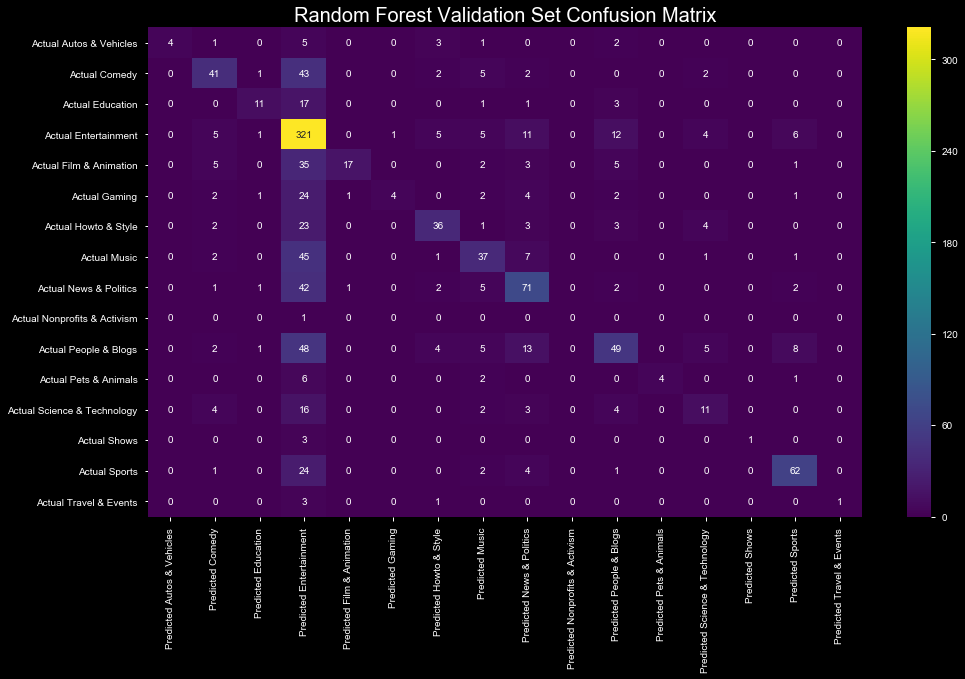

In [67]:
plot_confusion_matrix(y_val, y_pred_val)
plt.title('Random Forest Validation Set Confusion Matrix', fontsize=20);

## Multiclass Classification Report
Since a multiclass ROC/AUC score from the sklearn library is not possible and the standard classification report 
would not work either I found this function that will output Precision, Recall, and F1 needed. 

In [59]:
from scipy import interp
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [61]:
report_with_auc = class_report(y_true=y_val, y_pred=y_pred_val, y_score=pipeline.predict_proba(X_val))

rwa = pd.DataFrame(report_with_auc)

(rwa.loc[:]
    .style
    .background_gradient(cmap='inferno', low=0, high=.8)
    .highlight_null('red'))


,precision,recall,f1-score,support,pred,AUC
Autos & Vehicles,1,0.25,0.4,16,4,0.908658
Comedy,0.621212,0.427083,0.506173,96,66,0.849533
Education,0.6875,0.333333,0.44898,33,16,0.872197
Entertainment,0.489329,0.865229,0.625122,371,656,0.844546
Film & Animation,0.894737,0.25,0.390805,68,19,0.772516
Gaming,0.8,0.097561,0.173913,41,5,0.864185
Howto & Style,0.666667,0.5,0.571429,72,54,0.915458
Music,0.528571,0.393617,0.45122,94,70,0.876125
News & Politics,0.581967,0.559055,0.570281,127,122,0.889448
People & Blogs,0.590361,0.362963,0.449541,135,83,0.580227


In [64]:
print(f'The average AUC from Random Forest is : {rwa.loc[:,"AUC"].mean()}')

The average AUC from Random Forest is : 0.7251676305813824


__On the validation data the AUC for 10 of the 17 labels exceeded 80% with all others still over 40%.  A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0__

### Precision and Recall

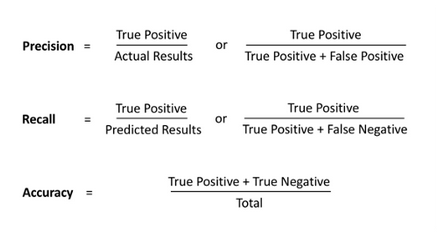

If the model says a label is Education, then 87% of times it is right then thats not bad.
Where this model fails a bit is recall on Education, which means he only detected as Education 37.6% of all 1s available. So if your aim is to build a diagnostic test, where Education is an important label, you should attempt to improve the recall ofthe model.

### F1 Score
f1-score is a quantity that tries to combine precision and recall in one number to penalize models that despite having high accuracy for example have low recall for one class https://en.wikipedia.org/wiki/Precision_and_recall



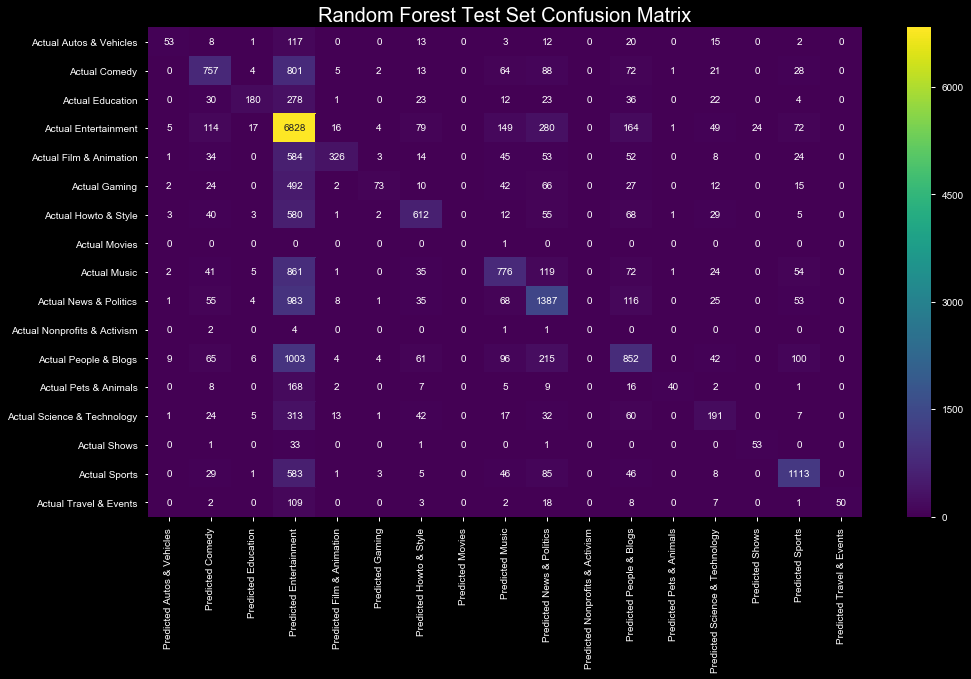

In [65]:
#Test Set Predict and Confusion Matrix

y_pred_x = pipeline.predict(X_test)
y_pred_proba_x  = pipeline.predict_proba(X_test)
accuracy_score(y_test, y_pred_x)

plot_confusion_matrix(y_test, y_pred_x)
plt.title('Random Forest Test Set Confusion Matrix', fontsize=20);

## Naive Bayes Classification

__The Multinomial Naive Bayes resulted in only slightly higher that baseline prediction F1 or accuracy score.  Naive Bayes assumes a good independence between features and is usually good at descrete word count text problems.  Because of engineering the tags for each label onto our model it may have convoluted the features rendering this method less reliable__

In [68]:
from sklearn.naive_bayes import MultinomialNB

labels = df.category_names.tolist()

pipeline = make_pipeline(
    ce.OrdinalEncoder(cols = cats),
    MultinomialNB(alpha=.01)
    
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)


# Predict and score the vectors
y_pred = pipeline.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred, labels = labels, average='macro')

print('Total accuracy classification score: {}'.format(acc_score))
print('Total F1 classification score: {}'.format(f1_score))

Total accuracy classification score: 0.36173905856097865
Total F1 classification score: 0.2828750035819032


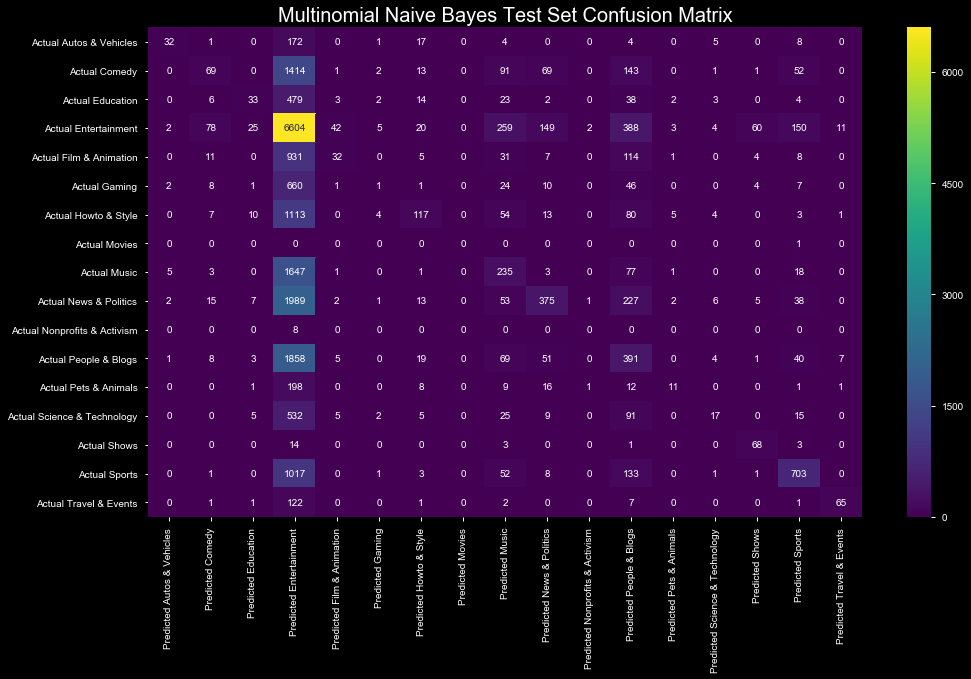

In [69]:

plot_confusion_matrix(y_test, y_pred)
plt.title('Multinomial Naive Bayes Test Set Confusion Matrix', fontsize=20);

## Linear Support Vector Model

### One vs All approach


__In order to look at the AUC/ROC for a Multilabel Classification Problem, you have to convert your problem into binary by using OneVsAll approach so you'll have n_class number of ROC curves__

__One-against-all classification, in which there is one binary SVM for each class is used to separate members of that class from members of other classes. For example Entertainment is coded as 1 and all others 0 or False. The Linear SVM then cuts a line through the data in order to distinguish the binary data and then works through the next labels sequential via the same method. At the end all of the labels ROC/AUC is averaged to get an overall ROC/AUC for the classification__


In [70]:
#map the class names to coded numbers

colums = {'Entertainment':0,'News & Politics':1,
'People & Blogs':2,'Music':3,'Sports':4,
'Comedy':5,'Howto & Style':6,
'Film & Animation':7,'Gaming':8,
 'Science & Technology':9,
 'Education':10,'Pets & Animals':11,
 'Autos & Vehicles':12,'Travel & Events':13,
 'Shows':14,'Nonprofits & Activism':15,'Movies':16}
target = 'category_names'
df4[target] = df4[target].map(colums)

#make sure our % looks the same after mapping
df4[target].value_counts(normalize=True)

0    0.3214
1    0.1129
2    0.1015
3    0.0818
4    0.0800
5    0.0762
6    0.0588
7    0.0472
8    0.0319
9    0.0298
10   0.0252
11   0.0107
12   0.0102
13   0.0082
14   0.0035
15   0.0004
16   0.0000
Name: category_names, dtype: float64

In [71]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize

features = df4.columns


X = df4[features]

y = df4[target]

y = label_binarize(y, classes= range(18))
n_classes = 17

# shuffle and split training and test sets
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.33, random_state=0)

#encoder
enc = ce.OrdinalEncoder(cols=cats)
X_train = enc.fit_transform(X_train)
X_test = enc.fit_transform(X_test)

# classifier
clf = OneVsRestClassifier(LinearSVC(max_iter=10000, random_state=42))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


## Individual ROC Curve Plots Revealing LSVM AUC

In [72]:
#List of classes and coded number for labels for reference
colums

{'Entertainment': 0,
 'News & Politics': 1,
 'People & Blogs': 2,
 'Music': 3,
 'Sports': 4,
 'Comedy': 5,
 'Howto & Style': 6,
 'Film & Animation': 7,
 'Gaming': 8,
 'Science & Technology': 9,
 'Education': 10,
 'Pets & Animals': 11,
 'Autos & Vehicles': 12,
 'Travel & Events': 13,
 'Shows': 14,
 'Nonprofits & Activism': 15,
 'Movies': 16}

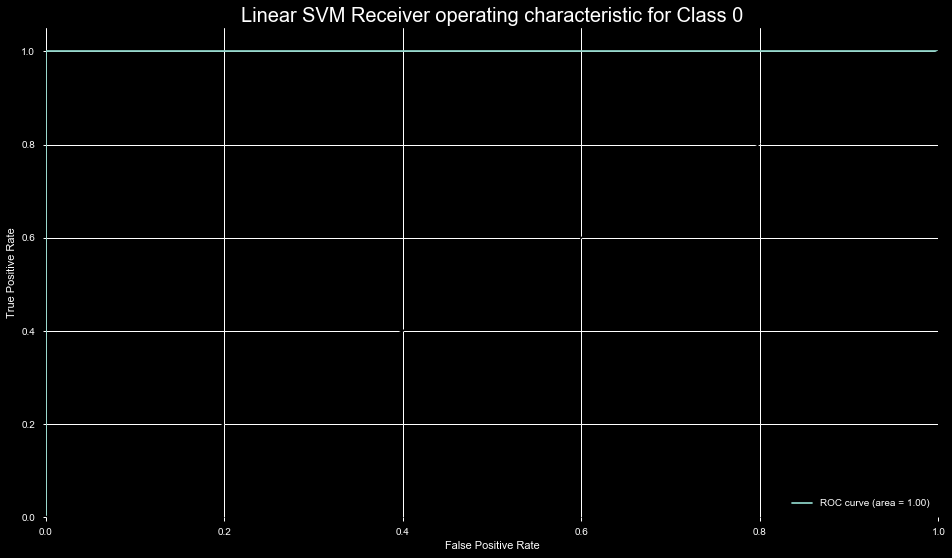

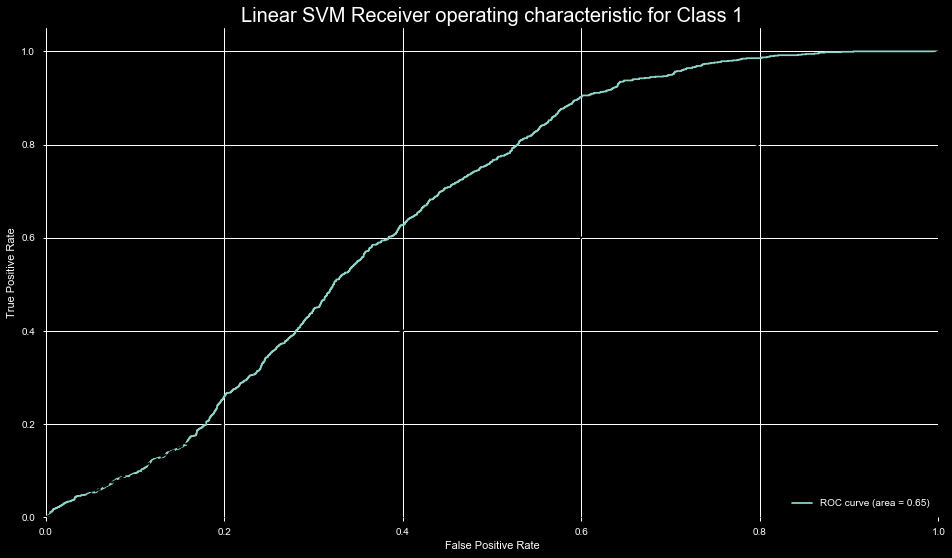

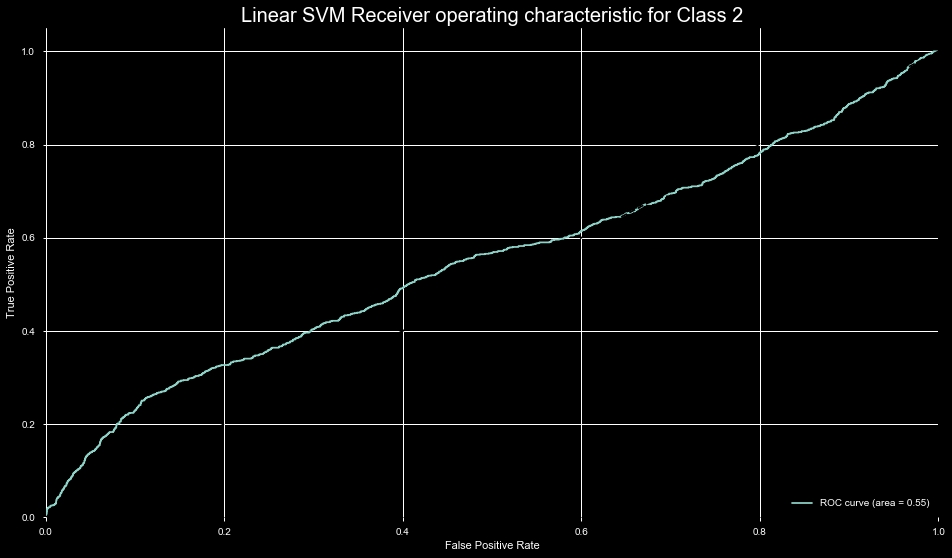

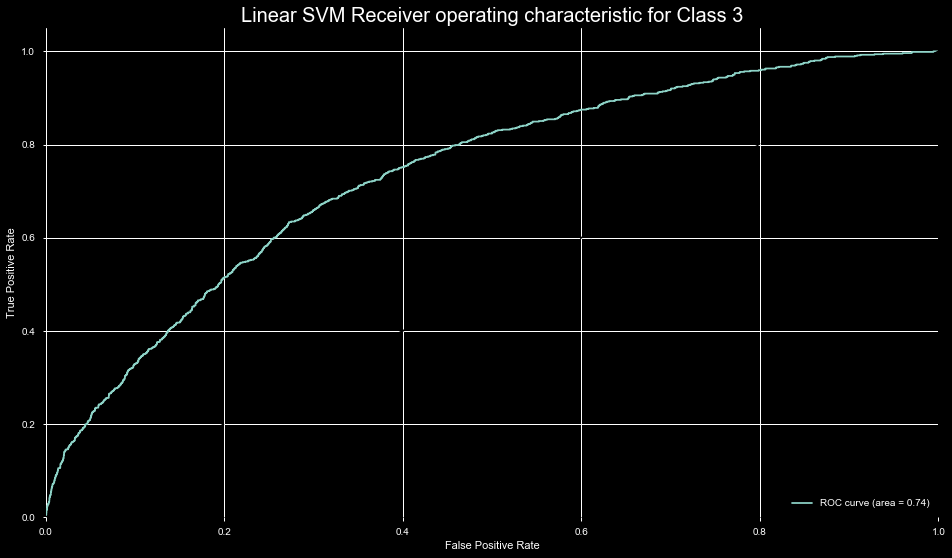

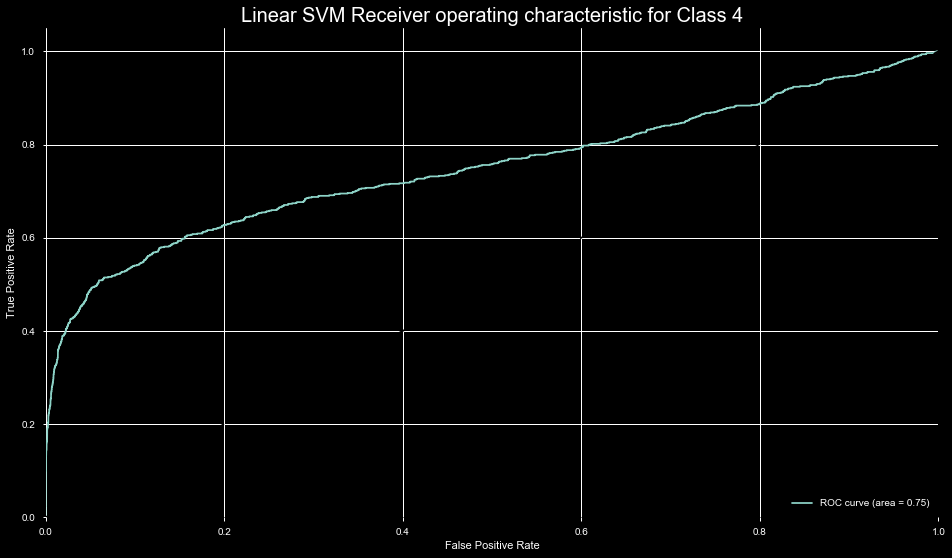

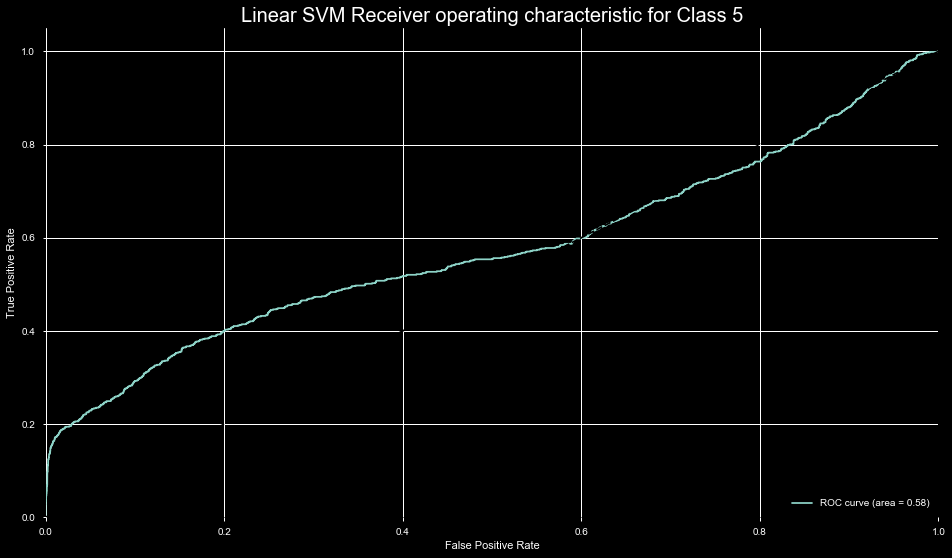

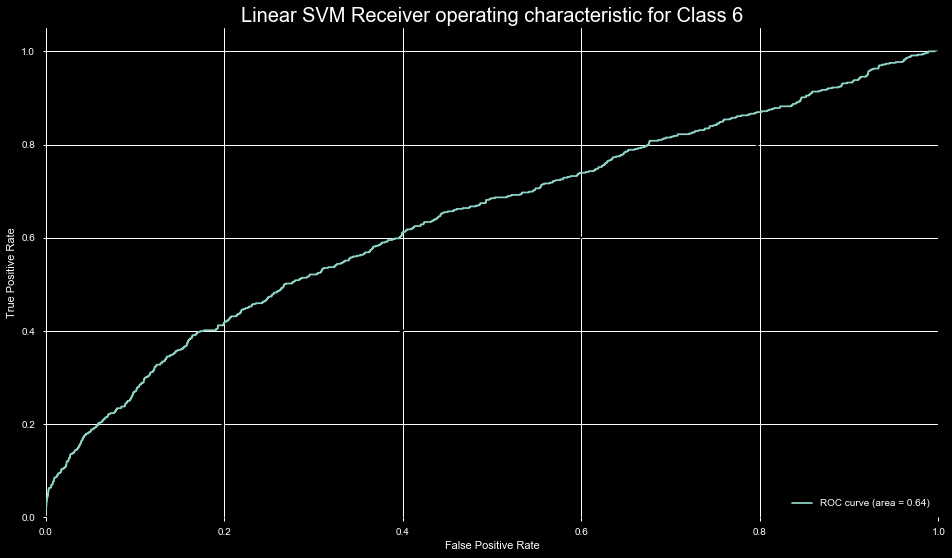

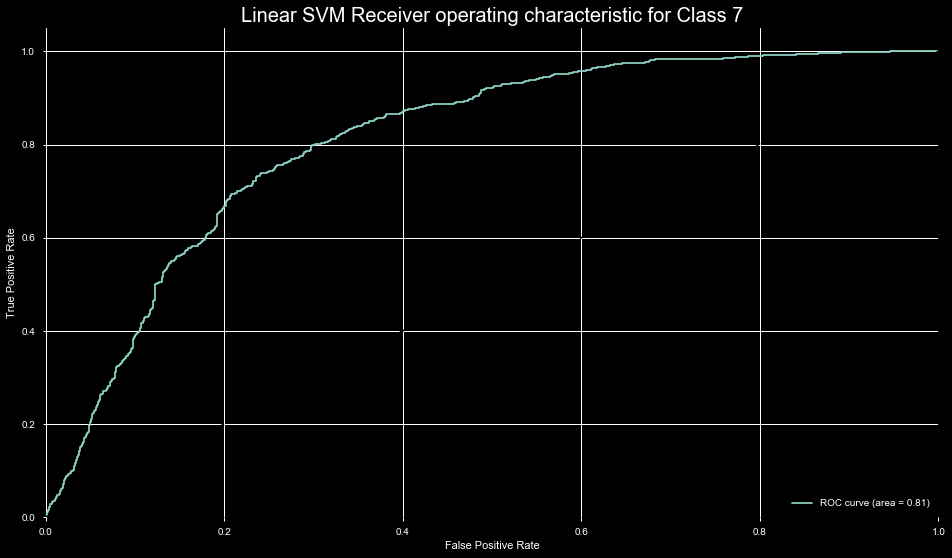

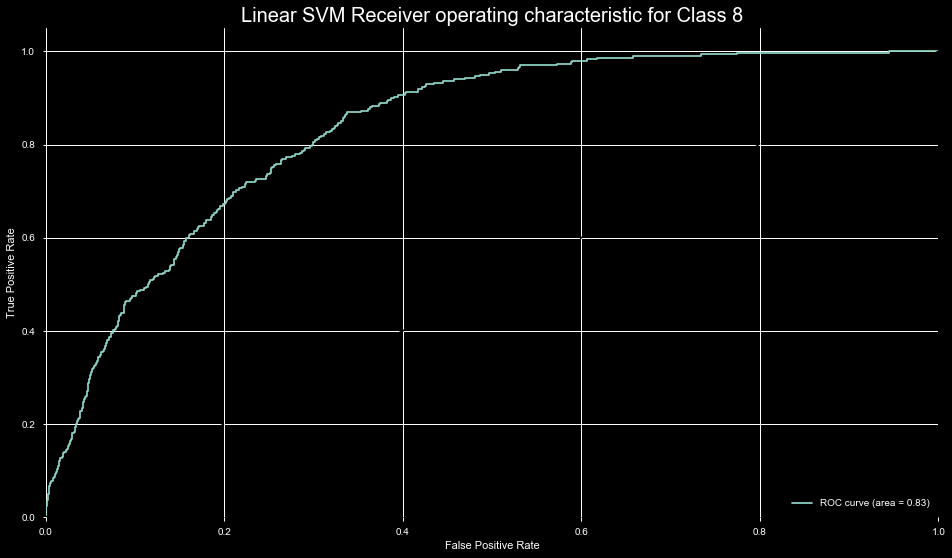

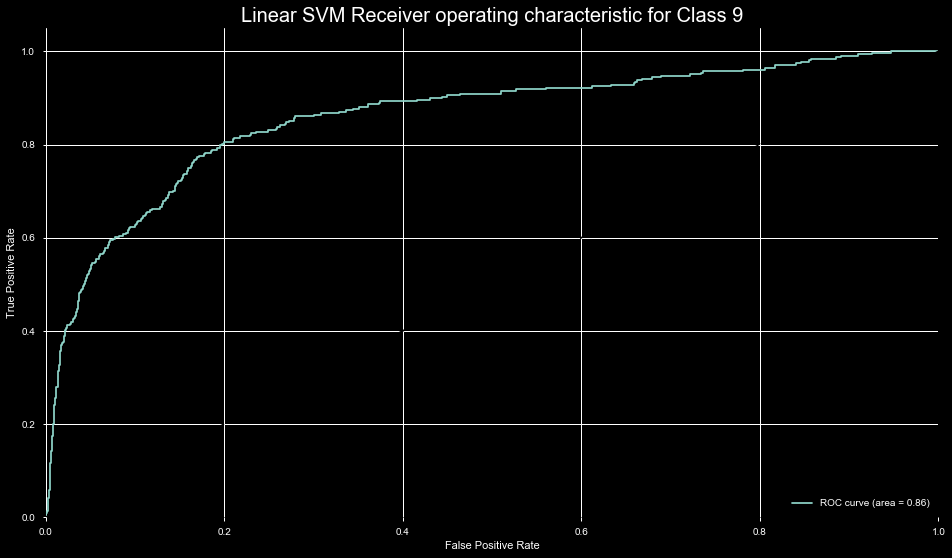

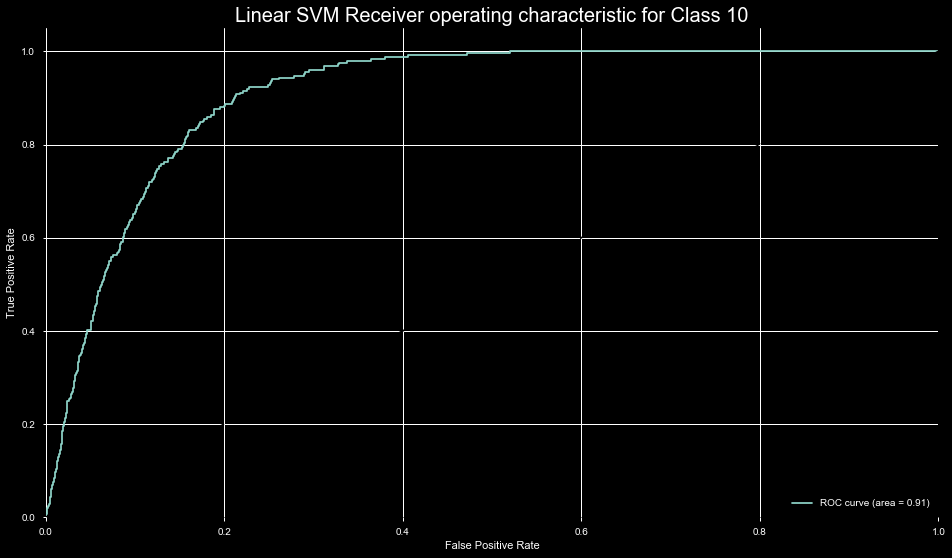

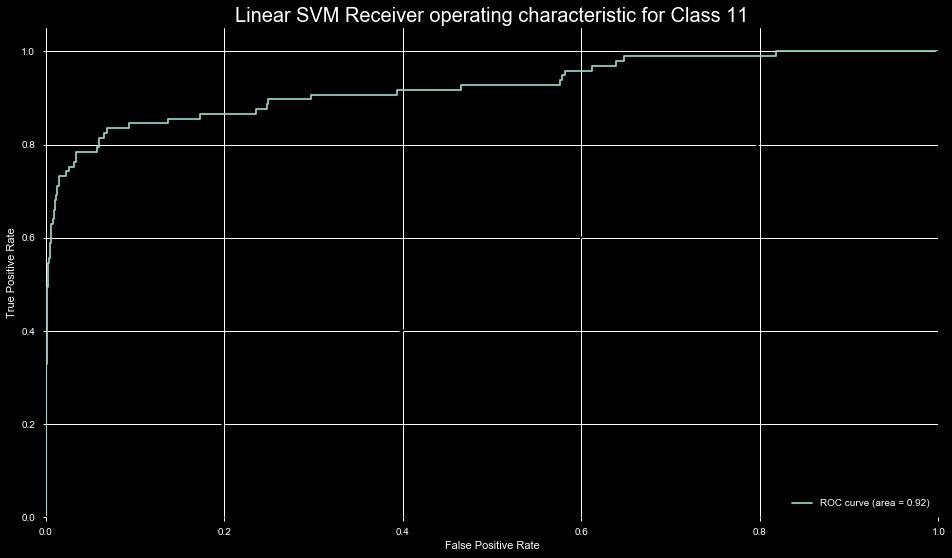

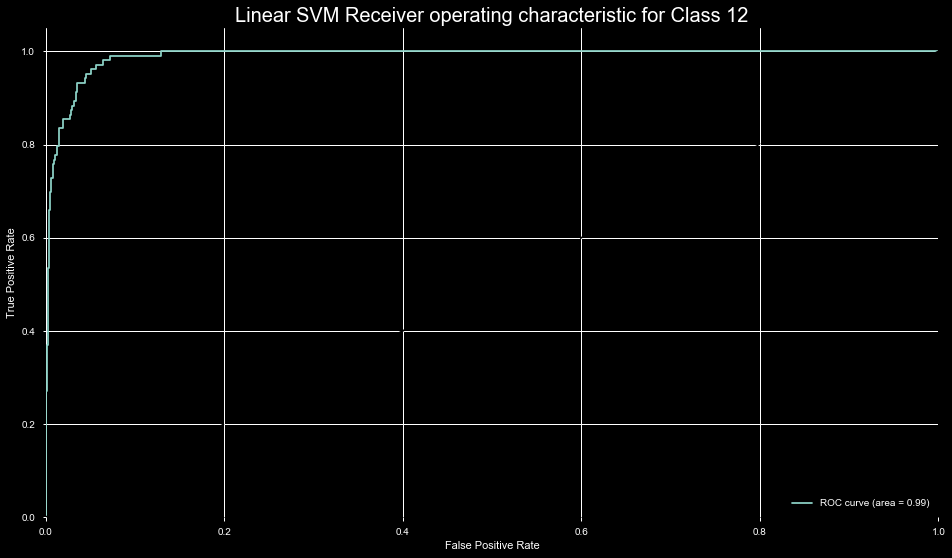

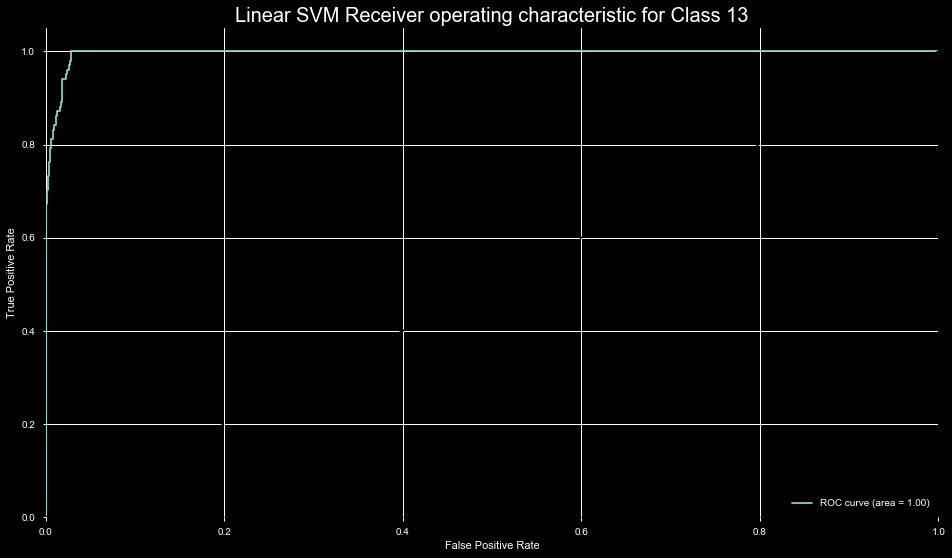

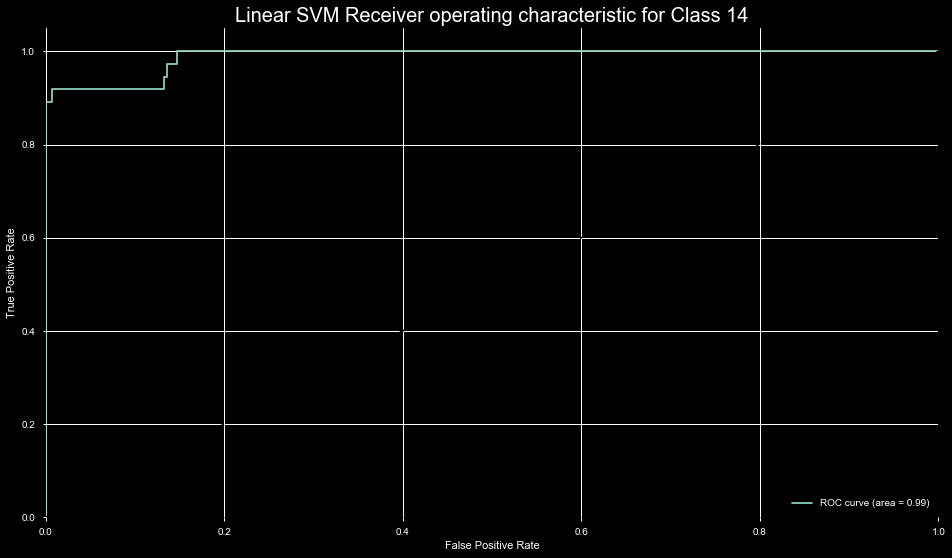

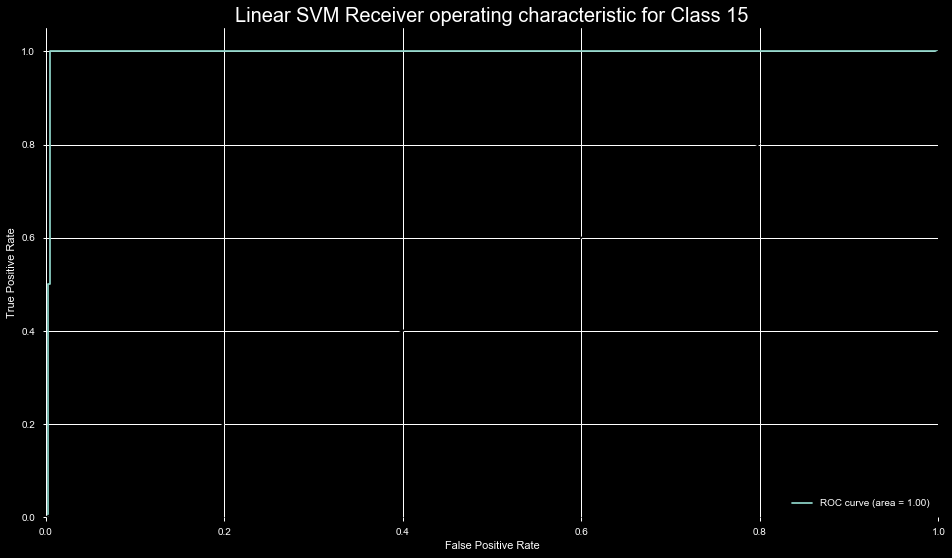

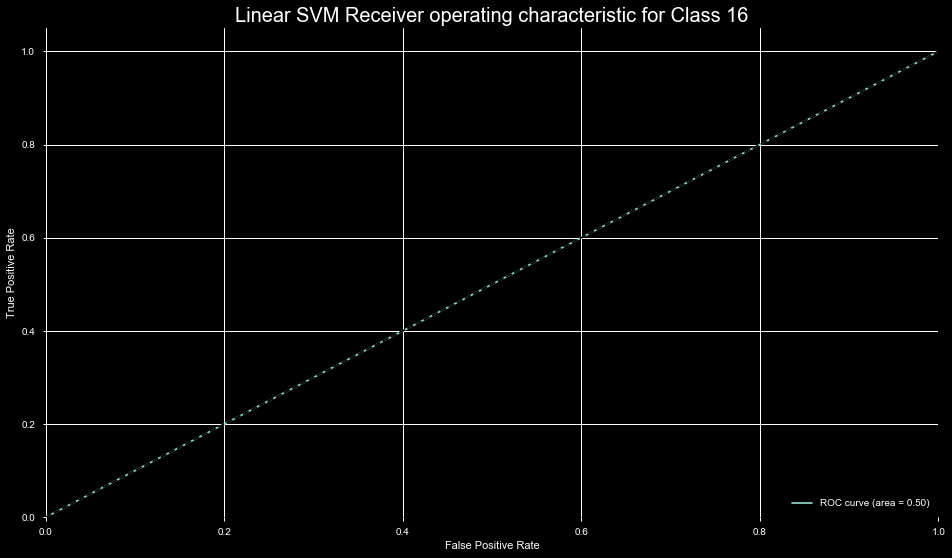

In [73]:

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(16,9))
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Linear SVM Receiver operating characteristic for Class {i}', fontsize=20)
    plt.legend(loc="lower right")
    plt.show()

## Average AUC for the Linear SVM

In [74]:
avg_list = [*roc_auc.values()]
pct = sum(avg_list) / len(avg_list)
print(f'The Average AUC on THe LSVM is {pct}')

The Average AUC on THe LSVM is 0.8065512271683959
